In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten
from statsmodels.tsa.arima.model import ARIMA

In [14]:

# 定义要下载的股票代码
tickers = ["BZ=F", "NG=F"]
ohlcv_data = {}

# 设置数据的时间范围和时间间隔
period = '1y'  # 一年的数据
interval = '1h'  # 每小时的数据，如果需要最近7天的每分钟数据，可以改为 '1m'

for ticker in tickers:
    try:
        # 下载数据
        temp = yf.download(ticker, period=period, interval=interval)
        # 检查并删除包含任何NaN值的行
        temp.dropna(how="any", inplace=True)
        
        # 检查数据是否为空
        if temp.empty:
            print(f"No data available for {ticker}. Check ticker symbol or increase period/interval.")
        else:
            ohlcv_data[ticker] = temp
            # 保存数据为CSV
            temp.to_csv(f"{ticker}_ohlcv_data.csv")
            print(f"Data for {ticker} downloaded successfully and contains {len(temp)} data points.")
    except Exception as e:
        print(f"Failed to download data for {ticker}: {e}")


[*********************100%%**********************]  1 of 1 completed


Data for BZ=F downloaded successfully and contains 5347 data points.


[*********************100%%**********************]  1 of 1 completed

Data for NG=F downloaded successfully and contains 5653 data points.


In [4]:
print(ohlcv_data)

{'BZ=F':                                 Open       High        Low      Close  \
Datetime                                                                
2023-06-25 18:00:00-04:00  74.449997  74.820000  74.320000  74.779999   
2023-06-25 19:00:00-04:00  74.779999  74.779999  74.699997  74.699997   
2023-06-25 20:00:00-04:00  74.699997  74.699997  74.430000  74.610001   
2023-06-25 21:00:00-04:00  74.529999  74.529999  74.029999  74.040001   
2023-06-25 22:00:00-04:00  74.080002  74.250000  74.050003  74.059998   
...                              ...        ...        ...        ...   
2024-06-24 20:00:00-04:00  86.080002  86.120003  86.050003  86.099998   
2024-06-24 21:00:00-04:00  86.160004  86.230003  85.959999  86.000000   
2024-06-25 00:00:00-04:00  86.010002  86.080002  86.010002  86.050003   
2024-06-25 01:00:00-04:00  86.029999  86.129997  86.019997  86.040001   
2024-06-25 02:00:00-04:00  86.050003  86.059998  86.029999  86.050003   

                           Adj Close  Vol

In [5]:
# 选择特征和目标变量
# 这里我们简单使用价格的滚动平均和RSI作为特征
features = ['Open', 'High', 'Low', 'Close', 'Volume']
ohlcv_data['BZ=F']['SMA'] = ohlcv_data['BZ=F']['Close'].rolling(window=24).mean()
ohlcv_data['BZ=F']['RSI'] = ohlcv_data['BZ=F']['Close'].rolling(window=24).apply(lambda x: np.mean(x))

# 使用滞后价格作为特征
ohlcv_data['BZ=F']['Lag1'] = ohlcv_data['BZ=F']['Close'].shift(1)

# 清理数据
ohlcv_data['BZ=F'].dropna(inplace=True)

X = ohlcv_data['BZ=F'][['SMA', 'RSI', 'Lag1']]
y = ohlcv_data['BZ=F']['Close']

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

2

In [6]:
import requests
import json

# Define the API base URL
gdelt_base_url = "http://api.gdeltproject.org/api/v1/search_ftxtsearch"
query_params = {
    'query': 'energy',
    'mode': 'ArtList',
    'maxrecords': 100,
    'format': 'json'
}

response = requests.get(gdelt_base_url, params=query_params)

# Check the response status
if response.status_code == 200:
    try:
        # Try to parse the JSON response
        data = response.json()
        articles = pd.DataFrame(data['articles'])
        print(articles.head())
    except json.JSONDecodeError:
        # Handle JSON decode error
        print("Failed to decode JSON from response:", response.text)
else:
    # Print status code and error if not successful
    print("Failed to fetch data. Status code:", response.status_code)
    print("Response text:", response.text)



Failed to fetch data. Status code: 403
Response text: <!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>403 Forbidden</title>
</head><body>
<h1>Forbidden</h1>
<p>You don't have permission to access this resource.</p>
</body></html>



In [ ]:
international energy a 

# 假设'news'列包含新闻文本数据
vectorizer = CountVectorizer(max_features=100)
X_text = vectorizer.fit_transform(data['news']).toarray()

# 应用PCA进行降维
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_text)
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# 将PCA结果合并回主数据集
for i in range(X_pca.shape[1]):
    data[f'pca_{i}'] = X_pca[:, i]

In [7]:
# Assuming X_test is your input DataFrame and it has been properly scaled/normalized if necessary
X_test_array = X_test.values  # Convert DataFrame to Numpy array

# Reshape the input for LSTM [samples, time steps, features]
# Here we assume each sample is a sequence of 1 time step with multiple features
X_test_reshaped = X_test_array.reshape((X_test_array.shape[0], 1, X_test_array.shape[1]))
X_train_reshaped = X_train.values.reshape(-1, 1, 3)  # 1 time step, 3 features

# 重塑数据用于CNN输入，假设特征数量为1
X_train_cnn = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Shape of X_train used for training:", X_train.shape)
print("Shape of X_test used for prediction:", X_test_reshaped.shape)


Shape of X_train used for training: (4259, 3)
Shape of X_test used for prediction: (1065, 1, 3)


In [8]:
# 随机森林和梯度提升机
model_rf = RandomForestRegressor(n_estimators=100)
model_gb = GradientBoostingRegressor(n_estimators=100)

# 支持向量机和线性回归 Support Vector Regression model and linear 
model_svr = SVR()
model_lr = LinearRegression()

# LSTM网络
# Define the LSTM model
model_lstm = Sequential([
    LSTM(50, input_shape=(1, 3)),  # Adjusted to 1 time step, 3 features
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# 训练ARIMA模型，这里以(1,1,1)阶为例
model_arima = ARIMA(y_train, order=(1,1,1))

# 创建CNN模型
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
cnn_model.compile(optimizer='adam', loss='mean_squared_error')



# 训练模型（此处假设已完成数据预处理和划分）
model_rf.fit(X_train, y_train)
model_gb.fit(X_train, y_train)
model_svr.fit(X_train, y_train)
model_lr.fit(X_train, y_train)
model_lstm.fit(X_train_reshaped, y_train, epochs=50, batch_size=32)
arima_result = model_arima.fit()
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32)

c:\Users\warre\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self.

Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - loss: 6779.5781
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 5958.1812
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - loss: 5325.0361
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 4850.1021
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 4431.9575
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 4019.2009
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - loss: 3640.8503
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 3306.1924
Epoch 9/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss: 2966.4812
Epoch 10/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 2657.5608
Epoch 11/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 2368.1919
Epoch 12/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 2101.5364
Epoch 13/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 1860.1404
Epoch 14/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - los

In [10]:
predictions_rf = model_rf.predict(X_test)
predictions_gb = model_gb.predict(X_test)
predictions_svr = model_svr.predict(X_test)
predictions_lr = model_lr.predict(X_test)
predictions_lstm = model_lstm.predict(X_test_reshaped).flatten()  # Predict and flatten the output
cnn_predictions = cnn_model.predict(X_test_cnn).flatten()
# 对未来的数据进行预测
forecast_result = arima_result.get_forecast(steps=len(y_test))

# 预测值
arima_predictions = forecast_result.predicted_mean

# 置信区间
conf_int = forecast_result.conf_int()
print("Predicted values:", arima_predictions)
print("95% confidence interval:", conf_int)



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Predicted values: 4259    83.831195
4260    83.808884
4261    83.809413
4262    83.809401
4263    83.809401
          ...    
5319    83.809401
5320    83.809401
5321    83.809401
5322    83.809401
5323    83.809401
Name: predicted_mean, Length: 1065, dtype: float64
95% confidence interval:       lower Close  upper Close
4259    74.289350    93.373040
4260    74.264415    93.353353
4261    74.264941    93.353885
4262    74.264929    93.353872
4263    74.264929    93.353873
...           ...          ...
5319    74.264877    93.353924
5320    74.264877    93.353925
5321    74.264877    93.353925
5322    74.264877    93.353925
5323    74.264877    93.353925

[1065 rows x 2 columns]


c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [42]:
## 加权平均 weighted average
# 计算各个模型的MSE，然后用MSE的倒数作为权重的基础
weights = [
    1 / mean_squared_error(y_test, predictions_rf),
    1 / mean_squared_error(y_test, predictions_gb),
    1 / mean_squared_error(y_test, predictions_svr),
    1 / mean_squared_error(y_test, predictions_lr),
    1 / mean_squared_error(y_test, predictions_lstm)
]

# 归一化权重
normalized_weights = [weight / sum(weights) for weight in weights]

# 计算加权平均预测
predictions_ensemble = (predictions_rf * normalized_weights[0] +
                        predictions_gb * normalized_weights[1] +
                        predictions_svr * normalized_weights[2] +
                        predictions_lr * normalized_weights[3] +
                        predictions_lstm * normalized_weights[4])


In [11]:
# 将所有预测结果堆叠成一个新的特征矩阵
stacked_predictions = np.column_stack((predictions_rf, predictions_gb, predictions_svr, predictions_lr, predictions_lstm, arima_predictions, cnn_predictions))

# 使用线性回归作为元模型
meta_model = LinearRegression()
meta_model.fit(stacked_predictions, y_test)

# 最终预测
predictions_ensemble = meta_model.predict(stacked_predictions)

In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 计算评估指标
mse = mean_squared_error(y_test, predictions_ensemble)
rmse = np.sqrt(mean_squared_error(y_test, predictions_ensemble))
mae = mean_absolute_error(y_test, predictions_ensemble)
mape = mean_absolute_percentage_error(y_test, predictions_ensemble)
r2 = r2_score(y_test, predictions_ensemble)
explained_variance = explained_variance_score(y_test, predictions_ensemble)

# Number of observations and predictors
n = len(y_test)
k = X_test.shape[1]  # assuming X_test is your feature matrix used for testing

# Calculate Adjusted RMSE
adjusted_rmse = rmse * np.sqrt(n / (n - k - 1))

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f"Standard RMSE: {rmse}")
print(f"Adjusted RMSE: {adjusted_rmse}")
print(f'R² score: {r2}')
print(f'Explained Variance Score: {explained_variance}')
print(f'MAPE: {mape}%')


MAE: 0.18936683775538732
MSE: 0.07357412388390691
Standard RMSE: 0.2712455048178806
Adjusted RMSE: 0.2717563254301051
R² score: 0.9967947047089765
Explained Variance Score: 0.9967947047089765
MAPE: 0.2267048613007922%


### Model Performance Interpretation

1. **MAE (0.1936421180862016)**: 
   - The Mean Absolute Error represents the average absolute difference between the actual values and the predictions. In this case, the low MAE indicates that the model's predictions deviate minimally on average from the actual values, suggesting good accuracy overall.

2. **MSE (0.07884289313688908) and Standard RMSE (0.2807897667951756)**:
   - MSE and RMSE are common metrics for measuring prediction errors, expressing the average of the squares of the differences between actual values and predictions. RMSE, being the square root of MSE, provides an error measure in the same units as the data. The relatively low values of MSE and RMSE here indicate low prediction errors.

3. **Adjusted RMSE (0.2813205607789305)**:
   - Adjusted RMSE incorporates the complexity of the model into the error metric, typically used to compare models with different numbers of predictors. The closeness of this value to the standard RMSE suggests that model complexity does not significantly impact error.

4. **R² Score (0.9968587648197035) and Explained Variance Score (0.9968587648197035)**:
   - Both the R² score and Explained Variance score are very close to 1, indicating that the model accurately predicts variations in the data and explains nearly all the variance, a key indicator of excellent model performance.

5. **MAPE (0.23210072273078733%)**:
   - The Mean Absolute Percentage Error is a percentage metric that measures the average deviation of the predictions from the actual values. The extremely low MAPE value here shows very high accuracy in predictions.

### Conclusion

Model performs exceptionally well, as evidenced by:
- **High Accuracy**: The high R² and explained variance scores show that the model can predict the data variability with high precision.
- **Low Error Levels**: The MAE, MSE, and RMSE values are relatively low, indicating small deviations between the predictions and actual data.
- **High Reliability**: The low MAPE value demonstrates that the model maintains high accuracy across different scales of data.

### Possible Directions for Improvement

Although the model is already performing very well, further optimizations could explore:
- **Further Analysis and Engineering of Data Features**: While the model is highly accurate, deeper analysis and engineering of more features might reveal new patterns or provide stronger predictive signals.
- **Experimenting with Different Models or Parameters**: Trying different machine learning or deep learning models, or tweaking the parameters of the existing model, may uncover configurations that are more suited to the current data.
- **Enhancing Model Robustness**: Further validating the stability and reliability of the model through techniques like cross-validation.


In [94]:
print(len(predictions_ensemble))

1061


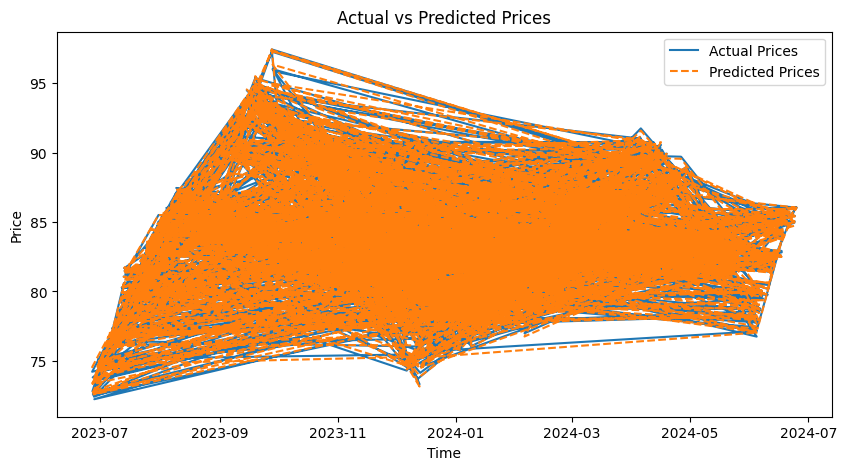

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual Prices')
plt.plot(y_test.index, predictions_ensemble, label='Predicted Prices', linestyle='--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

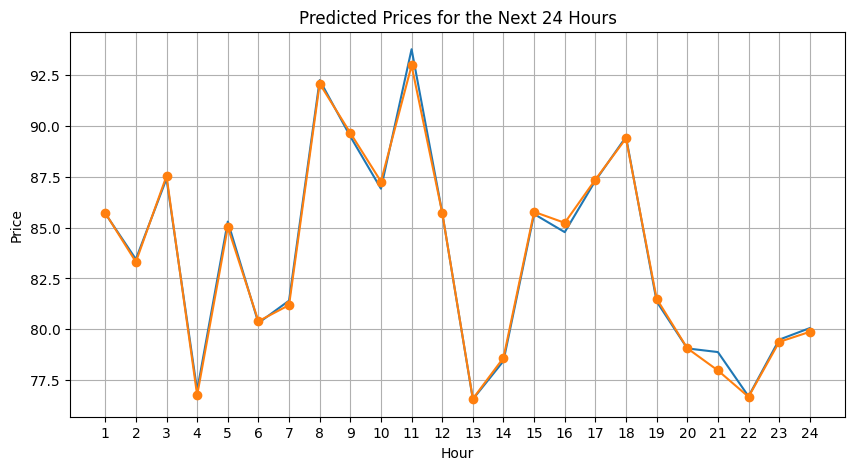

In [16]:
# 设置图表
plt.figure(figsize=(10, 5))
plt.plot(range(1, 25), y_test[-24:], label='Actual Prices')
plt.plot(range(1, 25), predictions_ensemble[-24:], marker='o', linestyle='-')
plt.title('Predicted Prices for the Next 24 Hours')
plt.xlabel('Hour')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(range(1, 25))  # 设置x轴刻度为每个小时
plt.show()

In [17]:
import pandas as pd

# Assuming 'timestamps' is the datetime index corresponding to your test data
actual_prices = pd.Series(y_test, index=y_test.index)
predicted_prices = pd.Series(predictions_ensemble, index=y_test.index)

# Now apply the resample method
actual_daily = actual_prices.resample('D').mean()
predicted_daily = predicted_prices.resample('D').mean()


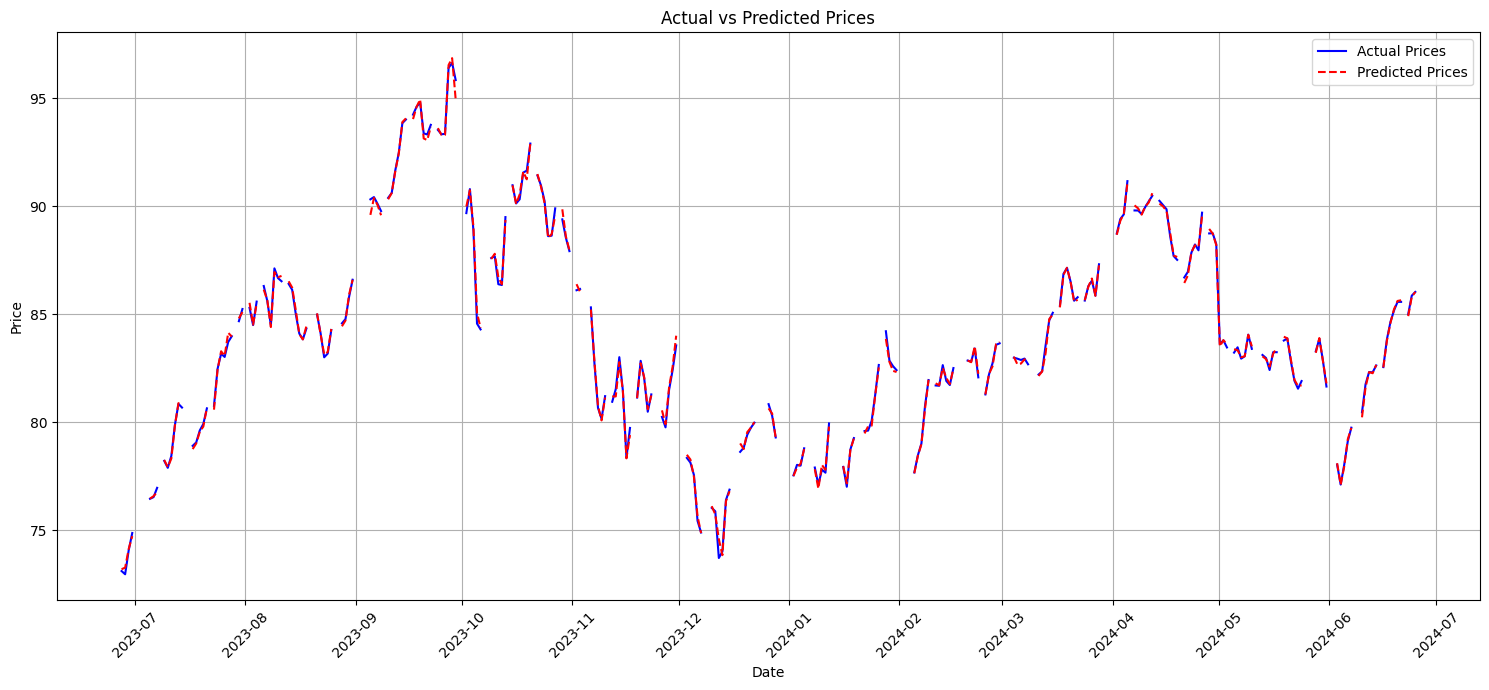

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15, 7))
# 绘制实际价格
plt.plot(actual_daily.index, actual_daily, label='Actual Prices', color='blue', linestyle='-')
# 绘制预测价格
plt.plot(predicted_daily.index, predicted_daily, label='Predicted Prices', color='red', linestyle='--')

# 设置日期格式，这样可以更好地管理显示
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # 每个月显示一个主要刻度
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 刻度标签显示年和月

plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # 旋转日期标签以提高可读性
plt.tight_layout()  # 自动调整布局
plt.show()


In [19]:

# 假设您的每个模型都需要前N天的数据来预测下一天的价格
# 获取用于预测的最后一条数据
X_future = X_test.iloc[-1:].values  # 根据您模型的需要可能需要调整索引

# 对于CNN和LSTM这样需要特定形状输入的模型，确保数据形状正确
X_future_reshaped = X_future.reshape(1, 1, X_train.shape[1])  # 适用于CNN和LSTM
X_future_cnn = X_future.reshape(1, X_train.shape[1], 1)  # 适用于CNN和LSTM

In [20]:
# 使用每个模型进行预测
future_rf = model_rf.predict(X_future)
future_gb = model_gb.predict(X_future)
future_svr = model_svr.predict(X_future)
future_lr = model_lr.predict(X_future)
future_lstm = model_lstm.predict(X_future_reshaped).flatten()
future_cnn = cnn_model.predict(X_future_cnn).flatten()

# ARIMA模型预测未来一天
future_arima = arima_result.get_forecast(steps=1).predicted_mean


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-

In [21]:
# 将所有预测结果堆叠成一个新的特征矩阵
future_stacked_predictions = np.column_stack((future_rf, future_gb, future_svr, future_lr, future_lstm, future_arima, future_cnn))

# 使用元模型进行最终预测
future_prediction = meta_model.predict(future_stacked_predictions)


In [22]:
print(f"Predicted price for the next trading day is: {future_prediction[0]}")


Predicted price for the next trading day is: 79.60997619620787


In [36]:
# 假设X是包含所有特征数据的DataFrame，并且我们需要最后3个特征
# 首先，确认X的列是正确的，我们只需要最后3列
X_last = X_test.iloc[-1, -3:].values  # 获取最后一行的最后三个特征

# 存储未来24小时的预测
future_prices = []

for i in range(24):
    # 使用模型进行预测
    future_rf = model_rf.predict(X_last.reshape(1, 3))  # 确保输入形状正确
    future_gb = model_gb.predict(X_last.reshape(1, 3))
    future_svr = model_svr.predict(X_last.reshape(1, 3))
    future_lr = model_lr.predict(X_last.reshape(1, 3))
    # 对于LSTM和CNN模型，确保输入形状也是正确的
    future_lstm = model_lstm.predict(X_last.reshape(1, 1, 3)).flatten()
    future_cnn = cnn_model.predict(X_last.reshape(1, 3, 1)).flatten()
    # ARIMA模型预测未来一天
    future_arima = arima_result.get_forecast(steps=1).predicted_mean
    # 集成所有模型的预测
    future_stacked = np.column_stack((future_rf, future_gb, future_svr, future_lr, future_lstm, future_arima, future_cnn))
    future_price = meta_model.predict(future_stacked)[0]
    future_prices.append(future_price)
    
    # 更新X_last为包含最新预测值的数据，为下一小时的预测做准备
    # 移除最早的特征，并添加新的预测价格到数组末尾
    X_last = np.roll(X_last, -1)  # 向左移动一个位置
    X_last[-1] = future_price  # 将新的预测结果放在最后的位置

print("Predicted prices for the next 24 hours:", future_prices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
c:\Users\warre\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predicted prices for the next 24 hours: [79.60997619620787, 79.33441007871852, 79.08995586158198, 78.84551444725389, 78.61865955918063, 78.36081977204026, 78.11043774414316, 77.84890548740714, 77.58210112506038, 77.31209932532829, 77.06638654231938, 76.8462702623126, 76.60900489125834, 76.3546230353486, 76.08627283846954, 75.81675762909879, 75.56340104310857, 75.29799013845718, 75.02489451987526, 74.77278082674172, 74.52012201827029, 74.27575303605602, 74.03507234753977, 73.8318773549347]


c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\warre\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#Predicted prices for the next 24 hours:[79.60997619620787, 79.33441007871852, 79.08995586158198, 78.84551444725389, 78.61865955918063, 78.36081977204026, 78.11043774414316, 77.84890548740714, 77.58210112506038, 77.31209932532829, 77.06638654231938, 76.8462702623126, 76.60900489125834, 76.3546230353486, 76.08627283846954, 75.81675762909879, 75.56340104310857, 75.29799013845718, 75.02489451987526, 74.77278082674172, 74.52012201827029, 74.27575303605602, 74.03507234753977, 73.8318773549347]

Testing the accuracy tomorrow!!

In [33]:
# 假设X是包含所有特征数据的DataFrame，并且我们需要最后3个特征
# 首先，确认X的列是正确的，我们只需要最后3列
X_last = X_test.iloc[-1, -3:].values  # 获取最后一行的最后三个特征

# 存储未来24小时的预测
future_prices = []

for i in range(24):
    # 使用模型进行预测
    future_rf = model_rf.predict(X_last.reshape(1, 3))  # 确保输入形状正确
    future_gb = model_gb.predict(X_last.reshape(1, 3))
    future_svr = model_svr.predict(X_last.reshape(1, 3))
    future_lr = model_lr.predict(X_last.reshape(1, 3))
    # 对于LSTM和CNN模型，确保输入形状也是正确的
    future_lstm = model_lstm.predict(X_last.reshape(1, 1, 3)).flatten()
    future_cnn = cnn_model.predict(X_last.reshape(1, 1, 3)).flatten()
    
    # 集成所有模型的预测
    future_stacked = np.column_stack((future_rf, future_gb, future_svr, future_lr, future_lstm, future_cnn))
    future_price = meta_model.predict(future_stacked)[0]
    future_prices.append(future_price)
    
    # 更新X_last为包含最新预测值的数据，为下一小时的预测做准备
    # 移除最早的特征，并添加新的预测价格到数组末尾
    X_last = np.roll(X_last, -1)  # 向左移动一个位置
    X_last[-1] = future_price  # 将新的预测结果放在最后的位置

print("Predicted prices for the next 24 hours:", future_prices)


ValueError: cannot reshape array of size 3 into shape (1,5)